In [1]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Directories
DATA_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\new updates"
TRAIN_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\train_data5"
VAL_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\val_data5"
TEST_DIR = r"C:\Users\farah\Desktop\ModelsTypesRun\test_data5"
IMG_SIZE = (299, 299)  # InceptionV3 input size
BATCH_SIZE = 16
EPOCHS = 20
MAX_IMAGES_PER_CLASS = 10000

# Dataset Preparation
def prepare_dataset(data_dir, train_dir, val_dir, test_dir, max_images_per_class, train_split=0.7, val_split=0.15):
    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split + val_split, random_state=42)
            val_images, test_images = train_test_split(test_images, train_size=val_split / (1 - train_split), random_state=42)

            train_class_dir = os.path.join(train_dir, class_name)
            val_class_dir = os.path.join(val_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(val_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in val_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(val_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))

# Check if the directory exists
print("Does DATA_DIR exist?", os.path.exists(DATA_DIR))

# If it does not exist, print an error message
if not os.path.exists(DATA_DIR):
    print("Error: DATA_DIR does not exist! Please check the folder path.")

# Call the function
prepare_dataset(DATA_DIR, TRAIN_DIR, VAL_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2],
    channel_shift_range=50.0
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Does DATA_DIR exist? True
Found 12639 images belonging to 3 classes.
Found 1114 images belonging to 3 classes.
Found 1118 images belonging to 3 classes.


In [3]:
# Model Definition
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
for layer in base_model.layers[:-20]:  # Freeze all layers except the last 20
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
checkpoint = ModelCheckpoint(
    filepath=os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "inceptionv3_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)
csv_logger = CSVLogger(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", 'inceptionv3_training_log.csv'))
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler, early_stopping]
)

# Save the Final Model
model.save(os.path.join(r"C:\Users\farah\Desktop\ModelsTypesRun", "inceptionv3_final_model.keras"))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1244s 14us/step


c:\Users\farah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1277s 2s/step - accuracy: 0.5856 - loss: 10.0602 - val_accuracy: 0.6643 - val_loss: 5.0033 - learning_rate: 1.0000e-04
Epoch 2/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1118s 1s/step - accuracy: 0.6725 - loss: 4.2057 - val_accuracy: 0.6849 - val_loss: 2.4945 - learning_rate: 1.0000e-04
Epoch 3/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1130s 1s/step - accuracy: 0.6855 - loss: 2.1897 - val_accuracy: 0.6786 - val_loss: 1.5337 - learning_rate: 1.0000e-04
Epoch 4/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1135s 1s/step - accuracy: 0.6915 - loss: 1.3999 - val_accuracy: 0.6777 - val_loss: 1.1441 - learning_rate: 1.0000e-04
Epoch 5/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1120s 1s/step - accuracy: 0.7189 - loss: 1.0460 - val_accuracy: 0.6535 - val_loss: 0.9978 - learning_rate: 1.0000e-04
Epoch 6/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1041s 1s/step - accuracy: 0.7247 - loss: 0.8886 - val_accuracy: 0.7136 - val_loss: 0.8265 - learning_rate: 1.0000e-04
Epoch 7/20
790/790 ━━━━━━━━━━━━━━━━━━━━ 1106s 1s/st

70/70 ━━━━━━━━━━━━━━━━━━━━ 63s 897ms/step - accuracy: 0.8375 - loss: 0.4368
Inceptionv3 Test Accuracy: 0.75
70/70 ━━━━━━━━━━━━━━━━━━━━ 68s 939ms/step


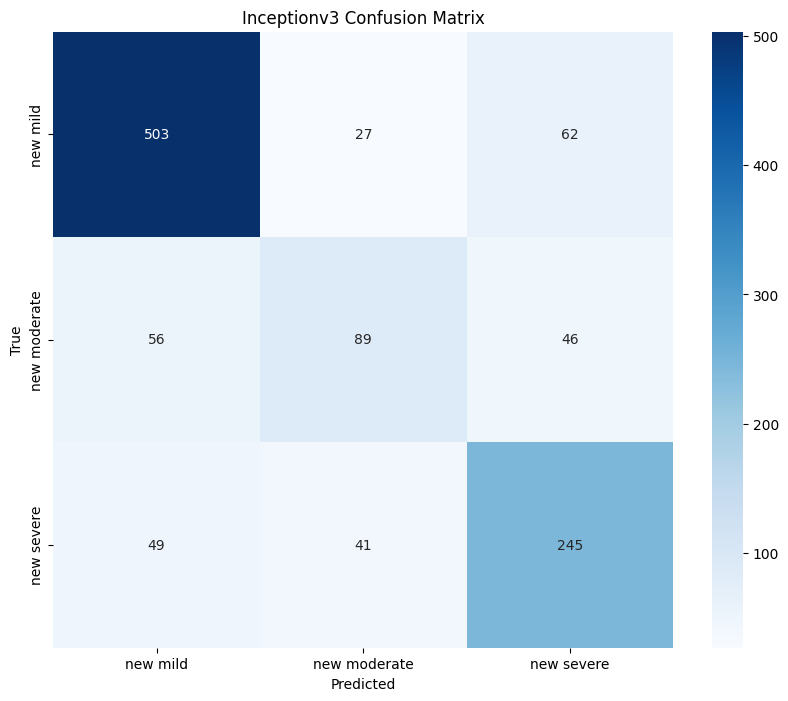

              precision    recall  f1-score   support

    new mild       0.83      0.85      0.84       592
new moderate       0.57      0.47      0.51       191
  new severe       0.69      0.73      0.71       335

    accuracy                           0.75      1118
   macro avg       0.70      0.68      0.69      1118
weighted avg       0.74      0.75      0.74      1118



In [4]:
# Evaluate the Model
test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Inceptionv3 Test Accuracy: {test_accuracy:.2f}")

# Predictions and Metrics
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Inceptionv3 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))